In [61]:
#import library
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import os
import time
import pickle

In [63]:
# IMAGES PATH
dataset_path = '../data/ENZ_crop/'
# CSV PATH
df = pd.read_csv('../data/data_618_final.csv')

# CHANGE COLUMN NAME
df['Depth(km)'] = df['Depth']
df.drop('Depth',axis=1,inplace=True)
df['foldername'] = df['filename'].apply(lambda x: x+'crop')

df

,Unnamed: 0,No,filename,Date,Hr,Min,Sec,Lat,Long,Mag,...,PA_start_real,flag_start,PA_start,datetime,seconds,time,foldername,PA,cluster_class,Depth(km)
0,0,0,20090118_064750,18/01/2009,6,47,50,-9.13465,114.535,4.6,...,194,269,275,00:15.5,15.510,15.510,20090118_064750crop,200,5,54.570
1,1,1,20090119_171408,19/01/2009,17,14,9,-8.89110,111.814,3.1,...,200,275,275,00:17.0,16.970,16.970,20090119_171408crop,200,3,36.888
2,2,2,20090119_211141,19/01/2009,21,11,41,-8.62730,113.663,3.9,...,200,275,275,00:14.9,14.946,14.946,20090119_211141crop,200,13,92.661
3,3,3,20090120_123437,20/01/2009,12,34,34,-10.61305,114.893,4.9,...,197,272,275,00:33.7,33.725,33.575,20090120_123437crop,197,5,55.502
4,4,4,20090120_134800,20/01/2009,13,47,57,-10.56872,114.862,3.7,...,200,275,275,00:33.2,33.156,33.156,20090120_134800crop,200,5,43.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,663,712,20170818_084429,18/08/2017,8,44,29,-11.35369,112.160,4.6,...,200,275,275,00:49.4,49.359,49.359,20170818_084429crop,200,7,66.033
614,664,713,20170824_053322,24/08/2017,5,33,22,-9.35305,112.741,3.6,...,198,273,275,00:21.4,21.440,21.440,20170824_053322crop,200,0,7.439
615,665,714,20170901_034735,1/9/2017,3,47,35,-11.35750,112.808,4.7,...,200,275,275,00:49.5,49.533,49.533,20170901_034735crop,200,7,61.404
616,666,715,20170910_044804,10/9/2017,4,48,4,-7.04644,114.197,3.3,...,200,275,275,00:23.0,22.998,22.998,20170910_044804crop,200,4,10.067


In [64]:
## SELECT PA VALUES
df['PA'] = df.apply(lambda x: x['flag_start']-75 if x['Unpick']!=0 else x['PA_start']-75,axis=1)
df = df[df.PA>=0]
df['PA'] = df.PA.apply(lambda x: int(x))

## CREATE PA DICTIONARIES
PA = {}
for i in range(df.shape[0]):
    PA[df.filename.values[i]+"crop"] = df.PA.values[i]

df

,Unnamed: 0,No,filename,Date,Hr,Min,Sec,Lat,Long,Mag,...,PA_start_real,flag_start,PA_start,datetime,seconds,time,foldername,PA,cluster_class,Depth(km)
0,0,0,20090118_064750,18/01/2009,6,47,50,-9.13465,114.535,4.6,...,194,269,275,00:15.5,15.510,15.510,20090118_064750crop,200,5,54.570
1,1,1,20090119_171408,19/01/2009,17,14,9,-8.89110,111.814,3.1,...,200,275,275,00:17.0,16.970,16.970,20090119_171408crop,200,3,36.888
2,2,2,20090119_211141,19/01/2009,21,11,41,-8.62730,113.663,3.9,...,200,275,275,00:14.9,14.946,14.946,20090119_211141crop,200,13,92.661
3,3,3,20090120_123437,20/01/2009,12,34,34,-10.61305,114.893,4.9,...,197,272,275,00:33.7,33.725,33.575,20090120_123437crop,197,5,55.502
4,4,4,20090120_134800,20/01/2009,13,47,57,-10.56872,114.862,3.7,...,200,275,275,00:33.2,33.156,33.156,20090120_134800crop,200,5,43.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,663,712,20170818_084429,18/08/2017,8,44,29,-11.35369,112.160,4.6,...,200,275,275,00:49.4,49.359,49.359,20170818_084429crop,200,7,66.033
614,664,713,20170824_053322,24/08/2017,5,33,22,-9.35305,112.741,3.6,...,198,273,275,00:21.4,21.440,21.440,20170824_053322crop,200,0,7.439
615,665,714,20170901_034735,1/9/2017,3,47,35,-11.35750,112.808,4.7,...,200,275,275,00:49.5,49.533,49.533,20170901_034735crop,200,7,61.404
616,666,715,20170910_044804,10/9/2017,4,48,4,-7.04644,114.197,3.3,...,200,275,275,00:23.0,22.998,22.998,20170910_044804crop,200,4,10.067


In [65]:
# SELECT DATA BY A NUMBER OF CLUSTER
minimum_gempa = 1
selected_clusters =  [c for c in sorted(df.Cluster.unique()) if len(df[df.Cluster==c])>=minimum_gempa]
df = df[df.Cluster.isin(selected_clusters)]

# CREATE CLUSTER CLASS
make_cluster_class = {}
for i in range(len(selected_clusters)):
    make_cluster_class[selected_clusters[i]] = i
    print('Cluster',selected_clusters[i], '- Class',i)

df['cluster_class'] = df['Cluster'].apply(lambda x: make_cluster_class[x])

print('\nAfter selected:',df.shape[0],'row')

Cluster 1 - Class 0
Cluster 2 - Class 1
Cluster 3 - Class 2
Cluster 4 - Class 3
Cluster 6 - Class 4
Cluster 7 - Class 5
Cluster 8 - Class 6
Cluster 9 - Class 7
Cluster 11 - Class 8
Cluster 12 - Class 9
Cluster 13 - Class 10
Cluster 14 - Class 11
Cluster 15 - Class 12
Cluster 16 - Class 13
Cluster 17 - Class 14

After selected: 618 row


In [66]:
print('BEFORE NORMALIZATION')
print('Max Lat:',df['Lat'].max(),'\t\tMin Lat:',df['Lat'].min())
print('Max Long:',df['Long'].max(),'\tMin Long:',df['Long'].min())
print('Max Depth(km):',df['Depth(km)'].max(),'\tMin Depth(km):',df['Depth(km)'].min())
print('Max Mag:',df['Mag'].max(),'\t\tMin Mag:',df['Mag'].min())
print('Max Time:',df['time'].max(),'\t\tMin Time:',df['time'].min())

Max Lat: -6.642639999999999 		Min Lat: -11.5152
Max Long: 115.03299999999999 	Min Long: 111.53200000000001
Max Depth(km): 588.4259999999999 	Min Depth(km): 1.16
Max Mag: 6.5 		Min Mag: 3.0
Max Time: 74.122 		Min Time: 4.502


In [67]:
### NORMALIZATION
#coef_norm_lat = 3 
coef_norm_lat = df['Lat'].max() - df['Lat'].min() # min-max-normalization 0-1 

#coef_norm_long = 3
coef_norm_long = df['Long'].max() - df['Long'].min() # min-max-normalization 0-1

#coef_norm_mag = 6
coef_norm_magnitude = df['Mag'].max() - df['Mag'].min() # min-max-normalization 0-1

#coef_norm_mag = 6
coef_norm_depth = df['Depth(km)'].max() - df['Depth(km)'].min() # min-max-normalization 0-1

#coef_norm_time = 6
coef_norm_time = df['time'].max() - df['time'].min() # min-max-normalization 0-1

df['norm_lat'] = df['Lat'].apply(lambda x: (x - df['Lat'].min()) / coef_norm_lat)
df['norm_long'] = df['Long'].apply(lambda x: (x - df['Long'].min()) / coef_norm_long)
df['norm_magnitude'] = df['Mag'].apply(lambda x: (x - df['Mag'].min()) / coef_norm_magnitude)
df['norm_depth'] = df['Depth(km)'].apply(lambda x: (x - df['Depth(km)'].min()) / coef_norm_depth)
df['norm_time'] = df['time'].apply(lambda x: (x - df['time'].min()) / coef_norm_time)

In [68]:
print('AFTER NORMALIZATION')
print('Max norm_lat:',df['norm_lat'].max(),'\tMin norm_lat:',df['norm_lat'].min())
print('Max norm_long:',df['norm_long'].max(),'\tMin norm_long:',df['norm_long'].min())
print('Max norm_magnitude:',df['norm_magnitude'].max(),'\tMin norm_magnitude:',df['norm_magnitude'].min())
print('Max norm_depth:',df['norm_depth'].max(),'\tMin norm_depth:',df['norm_depth'].min())
print('Max norm_time:',df['norm_time'].max(),'\tMin norm_time:',df['norm_time'].min())

AFTER NORMALIZATION
Max norm_lat: 1.0 	Min norm_lat: 0.0
Max norm_long: 1.0 	Min norm_long: 0.0
Max norm_magnitude: 1.0 	Min norm_magnitude: 0.0
Max norm_depth: 1.0 	Min norm_depth: 0.0
Max norm_time: 1.0 	Min norm_time: 0.0


(616, 423, 3)
(256, 192, 3)


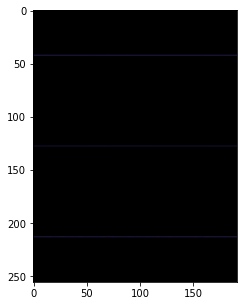

In [69]:
import cv2
import matplotlib.pyplot as plt

# GET IMAGE SIZE FROM DATASET
img = load_img(dataset_path+'20170428_014929crop/'+'000000_20170428_014929_crop.png')
x = img_to_array(img)
print(x.shape)
plt.figure(figsize=(5,5))
x = cv2.resize(x, (192, 256))
print(x.shape)
plt.imshow(x/255)

In [70]:
### GET DATA FROM FOLDER
all_images = []
list_folder_in_df = [fd for fd in os.listdir(dataset_path) if fd in df.foldername.values]
print('Jumlah folder:',len(os.listdir(dataset_path)),', irisan jumlah folder dengan dataframe:',len(list_folder_in_df))
df = df[df.foldername.isin(list_folder_in_df)]

Jumlah folder: 671 , irisan jumlah folder dengan dataframe: 618


In [71]:
df.head()

,Unnamed: 0,No,filename,Date,Hr,Min,Sec,Lat,Long,Mag,...,time,foldername,PA,cluster_class,Depth(km),norm_lat,norm_long,norm_magnitude,norm_depth,norm_time
0,0,0,20090118_064750,18/01/2009,6,47,50,-9.13465,114.535,4.6,...,15.510,20090118_064750crop,200,5,54.570,0.488562,0.857755,0.457143,0.090947,0.158115
1,1,1,20090119_171408,19/01/2009,17,14,9,-8.89110,111.814,3.1,...,16.970,20090119_171408crop,200,3,36.888,0.538546,0.080548,0.028571,0.060838,0.179086
2,2,2,20090119_211141,19/01/2009,21,11,41,-8.62730,113.663,3.9,...,14.946,20090119_211141crop,200,13,92.661,0.592686,0.608683,0.257143,0.155808,0.150014
3,3,3,20090120_123437,20/01/2009,12,34,34,-10.61305,114.893,4.9,...,33.575,20090120_123437crop,197,5,55.502,0.185149,0.960011,0.542857,0.092534,0.417596
4,4,4,20090120_134800,20/01/2009,13,47,57,-10.56872,114.862,3.7,...,33.156,20090120_134800crop,200,5,43.658,0.194247,0.951157,0.200000,0.072366,0.411577


In [73]:
# SPLITTING DATA INTO TRAIN VAL TEST

test_df = pd.read_csv('../data/data_test_val_final2.csv')
test_df = df[df.foldername.isin(test_df.foldername.values)]
train_df = df[~df.foldername.isin(test_df.foldername.values)]

list_folder_for_train = [__ for __ in train_df.foldername.values]
list_folder_for_validation = [__ for __ in test_df.foldername.values]
list_folder_for_test = list_folder_for_validation

print()
print('SPLIT THE DATASET:')
print('TRAIN:',len(list_folder_for_train))
print('VALIDATION:',len(list_folder_for_validation))
print('TEST:',len(list_folder_for_test))


Pembagian Dataset:
TRAIN: 556
VALIDATION: 62
TEST: 62


In [75]:
## Check redundant in train
for __ in list_folder_for_train:
    if __ in  list_folder_for_test+list_folder_for_validation:
        print(__)

In [76]:
### GET IMAGE NAMES FROM FOLDER

After_PA_start_second = 5
After_PA_end_second = 6

train_images = []
for fol in list_folder_for_train:
    train_images += [(fol,img) for img in os.listdir(dataset_path+fol) if '.png' in img and int(img[:6]) in range(PA[fol]+int(20*After_PA_start_second),
                                                                                                PA[fol]+int(20*After_PA_end_second)+1)]
print('train_images',len(train_images))

validation_images = []
for fol in list_folder_for_validation:
    validation_images += [(fol,img) for img in os.listdir(dataset_path+fol) if '.png' in img and int(img[:6]) in range(PA[fol]+int(20*After_PA_start_second),
                                                                                                     PA[fol]+int(20*After_PA_end_second)+1)]
print('validation_images',len(validation_images))

test_images = []
for fol in list_folder_for_test:
    test_images += [(fol,img) for img in os.listdir(dataset_path+fol) if '.png' in img and int(img[:6]) in range(PA[fol]+int(20*After_PA_start_second),
                                                                                               PA[fol]+int(20*After_PA_end_second)+1)]
print('test_images',len(test_images))

train_images 11676
validation_images 1302
test_images 1302


In [78]:
### LOAD DATASET 
def load_data(images_data,source_path,shuffle=False):
    ### DEFINE IMAGE
    train_data = np.zeros([len(images_data),x.shape[0],x.shape[1],3]) #grayscale 1, RGB 3
    ### DEFINE LABEL
    y_cluster = np.zeros([len(images_data),len(make_cluster_class)]) ###
    y_lat = np.zeros([len(images_data),1])
    y_long = np.zeros([len(images_data),1])
    y_depth = np.zeros([len(images_data),1])
    y_magnitude = np.zeros([len(images_data),1])
    y_time = np.zeros([len(images_data),1])
    
    img_ids = np.arange(len(images_data))

    if shuffle:
        np.random.shuffle(img_ids) # Shuffle image untuk setiap folder

    for i in img_ids:
        image_path = source_path + images_data[i][0] + '/' + images_data[i][1] 
        image = cv2.imread(image_path, 1) #grascale 0, RGB 1
        b,g,r = cv2.split(image) # comment jika grayscale
        image = cv2.merge([r,g,b]) # comment jika grayscale
        image = cv2.resize(image, (x.shape[1], x.shape[0]))
        image = image/255.0 # comment jika pake augmentasi
        
        ### ASSIGN IMAGE
        train_data[i,:,:,:] = image
        ### ASSIGN LABEL
        cluster_labels = df[df.foldername==images_data[i][1][7:-9]+'crop']['cluster_class'].values
        y_cluster[i,:] = keras.utils.to_categorical(cluster_labels, num_classes=len(make_cluster_class))
        y_lat[i,0] = df[df.foldername==images_data[i][1][7:-9]+'crop']['norm_lat'].values
        y_long[i,0] = df[df.foldername==images_data[i][1][7:-9]+'crop']['norm_long'].values
        y_depth[i,0] = df[df.foldername==images_data[i][1][7:-9]+'crop']['norm_depth'].values
        y_magnitude[i,0] = df[df.foldername==images_data[i][1][7:-9]+'crop']['norm_magnitude'].values
        y_time[i,0] = df[df.foldername==images_data[i][1][7:-9]+'crop']['norm_time'].values

    return train_data,y_cluster.astype(int),y_lat,y_long,y_depth,y_magnitude,y_time, img_ids ### LAT LONG DEPTH MAG TIME



In [79]:
### GENERATE DATASET

X_train,y_train_cluster,y_train_lat,y_train_long,y_train_depth,y_train_magnitude,y_train_time,img_train_ids = load_data(train_images,dataset_path,True)
print('Train data has been loaded')
X_valid,y_valid_cluster,y_valid_lat,y_valid_long,y_valid_depth,y_valid_magnitude,y_valid_time,img_valid_ids = load_data(validation_images,dataset_path)
print('Validation data has been loaded')
X_test,y_test_cluster,y_test_lat,y_test_long,y_test_depth,y_test_magnitude,y_test_time,img_test_ids = load_data(test_images,dataset_path)
print('Test data has been loaaded')

Train data has been loaded
Validation data has been loaded
Test data has been loaaded


In [80]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print('Shuffle train',img_train_ids[:10]) 

(11676, 256, 192, 3)
(1302, 256, 192, 3)
(1302, 256, 192, 3)
[ 6203   556  4196  7909  7800   111 10844  3275  1843 10252]


## Modeling

In [81]:
### name model = base_outputs_PAstart-PAend_customname == ex : CNN_multioutput_lat_long_5s-10s_custom_name

### postfix name model
custom_name = "base1024-64" 

##### MODELING

In [82]:
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return SS_res/(SS_tot + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [83]:
import keras
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

loss_function = 'mae'

def make_model(base="", output_names=[], custom_name=custom_name, loss_function=loss_function):
    m_ = None
    outputs = {}
    model_name = base.upper() + "_multioutput_" if len(output_names)>1 else base.upper() + "_singleoutput_"  
    model_name = model_name + "_".join(output_names) + "_"
    model_name = model_name + str(int((PA_start*0.05))) + "s-" + str(int((PA_end*0.05))) + "s"
    model_name = model_name + '_' + loss_function

    if base.lower()=="cnn":
        ### FOR CNN MODELS ###

        import keras
        base_model = Sequential()
        base_model.add(Conv2D(32, (3, 3), input_shape=(x.shape[0], x.shape[1], 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(64, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(128, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(256, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

### TUNNING SHARED-LAYER
        base_model.add(Flatten()) 
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
#         base_model.add(Dense(1024, kernel_initializer=keras.initializers.Orthogonal()))
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
        m_ = base_model.output

        ### --------------- ###

    elif base.lower()=="mobilenetv3":
        ### FOR MOBILENETV3 ###

        import keras
        from keras.applications import keras_applications
        from keras_applications.mobilenet_v3 import MobileNetV3Large, MobileNetV3Small

        base_model = MobileNetV3Large(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet', backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils) #RGB 3, grayscale 1

        # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
        for i, layer in enumerate(base_model.layers[1:]):
            layer.name = 'layer_' + str(i) + '_' + layer.name

        m_ = base_model.output

### TUNNING SHARED-LAYER
        m_ = GlobalAveragePooling2D()(m_)
        m_ = Dense(1024,activation='relu')(m_)
#         m_ = Dense(1024,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m_)
        m_ = Dense(1024,activation='relu')(m_)
#         m_ = Dense(1024,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m_)
        m_ = Dense(1024,activation='relu')(m_)
#         m_ = Dense(1024,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m_)
        
        ### --------------- ###
    elif base.lower()[:-1]=="efficientnetb":
        ### FOR EFFICIENTNET ###
        import keras

        from efficientnet.keras import EfficientNetB0,EfficientNetB1
        from efficientnet.keras import EfficientNetB2,EfficientNetB3
        from efficientnet.keras import EfficientNetB4,EfficientNetB5

        EFMODEL = {}
        EFMODEL['efficientnetb0'] = EfficientNetB0(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb1'] = EfficientNetB1(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb2'] = EfficientNetB2(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb3'] = EfficientNetB3(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb4'] = EfficientNetB4(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb5'] = EfficientNetB5(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1

        base_model = EFMODEL[base.lower()]
        # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
        for i, layer in enumerate(base_model.layers[1:]):
            layer.name = 'layer_' + str(i) + '_' + layer.name

        m_ = base_model.output

### TUNNING SHARED-LAYER
        m_ = GlobalAveragePooling2D()(m_)
        m_ = Dense(1024,activation='relu')(m_)
#         m_ = Dense(1024,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m_)
        m_ = Dense(1024,activation='relu')(m_)
#         m_ = Dense(1024,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m_)
        m_ = Dense(1024,activation='relu')(m_)
#         m_ = Dense(1024,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m_)
                
        ### --------------- ###
    else:
        print("Model Definition Error")

### NON-SHARED-LAYER
    for output_name in output_names:
        # multioutput
        m__ = m_
#         m__ = Dense(512,activation='relu')(m__) 
#         m__ = Dense(512,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m__) 
#         m__ = Dense(256,activation='relu')(m__) 
#         m__ = Dense(256,activation='relu', kernel_initializer=keras.initializers.Orthogonal())(m__) 
        outputs[output_name] = Dense(1, activation = 'linear', name = output_name)(m__)
        
    if len(output_names)==0: print("Outputs Definition Error")
    else:
        # single output 
        model = Model(inputs=base_model.input, outputs=[outputs[output_name] for output_name in output_names]) 
    
    model.compile(optimizer=Adam(1e-4),
                  loss=loss_function,   
                  metrics=[loss_function])
    
    model.name = model_name if custom_name is "" else model_name + "_" + custom_name
    
    return model


In [86]:
PA_start = After_PA_start_second * 20
PA_end = After_PA_end_second * 20

In [88]:
# CREATE FOLDER
model_save_path = "./models/EXPERIMENT_001/"
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

In [91]:
NSTEP = 20
Nbatch = 4

# CNN

In [31]:
model = make_model(base="cnn", output_names=["lat","long","depth","magnitude","time"])
y_train = {'lat':y_train_lat,'long':y_train_long,'depth':y_train_depth,'magnitude':y_train_magnitude,'time':y_train_time}
y_valid = {'lat':y_valid_lat,'long':y_valid_long,'depth':y_valid_depth,'magnitude':y_valid_magnitude,'time':y_valid_time}
y_test = {'lat':y_test_lat,'long':y_test_long,'depth':y_test_depth,'magnitude':y_test_magnitude,'time':y_test_time}
model.name

'CNN_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4'

In [32]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.00001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [33]:
# training models
history = model.fit(X_train,y_train, 
    validation_data = (X_valid,y_valid),
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[checkpoint,swa])

Train on 11676 samples, validate on 1302 samples
Epoch 1/50
11676/11676 [==============================] - 129s 11ms/step - loss: 0.6768 - lat_loss: 0.1532 - long_loss: 0.1238 - depth_loss: 0.1216 - magnitude_loss: 0.1410 - time_loss: 0.1373 - lat_mae: 0.1532 - long_mae: 0.1238 - depth_mae: 0.1216 - magnitude_mae: 0.1410 - time_mae: 0.1373 - val_loss: 0.3642 - val_lat_loss: 0.0979 - val_long_loss: 0.0525 - val_depth_loss: 0.0603 - val_magnitude_loss: 0.0842 - val_time_loss: 0.0691 - val_lat_mae: 0.0980 - val_long_mae: 0.0525 - val_depth_mae: 0.0603 - val_magnitude_mae: 0.0843 - val_time_mae: 0.0691

Epoch 00001: val_loss improved from inf to 0.36418, saving model to ./models/26-11-2020/CNN_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4/CNN_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4_best.h5
Epoch 2/50
11676/11676 [==============================] - 126s 11ms/step - loss: 0.3680 - lat_loss: 0.0961 - long_loss: 0.0621 - depth_loss: 0.0641 - magnitude_loss: 0.0762 - ti


Epoch 00024: val_loss improved from 0.25756 to 0.25680, saving model to ./models/26-11-2020/CNN_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4/CNN_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4_best.h5
Epoch 25/50
11676/11676 [==============================] - 126s 11ms/step - loss: 0.0402 - lat_loss: 0.0093 - long_loss: 0.0081 - depth_loss: 0.0069 - magnitude_loss: 0.0091 - time_loss: 0.0069 - lat_mae: 0.0093 - long_mae: 0.0081 - depth_mae: 0.0069 - magnitude_mae: 0.0091 - time_mae: 0.0069 - val_loss: 0.2585 - val_lat_loss: 0.0606 - val_long_loss: 0.0314 - val_depth_loss: 0.0555 - val_magnitude_loss: 0.0634 - val_time_loss: 0.0476 - val_lat_mae: 0.0606 - val_long_mae: 0.0315 - val_depth_mae: 0.0554 - val_magnitude_mae: 0.0634 - val_time_mae: 0.0476

Epoch 00025: val_loss did not improve from 0.25680
Epoch 26/50
11676/11676 [==============================] - 126s 11ms/step - loss: 0.0369 - lat_loss: 0.0085 - long_loss: 0.0074 - depth_loss: 0.0063 - magnitude_loss: 0.


Epoch 00037: val_loss did not improve from 0.25311
Epoch 38/50
11676/11676 [==============================] - 126s 11ms/step - loss: 0.0124 - lat_loss: 0.0027 - long_loss: 0.0026 - depth_loss: 0.0021 - magnitude_loss: 0.0029 - time_loss: 0.0022 - lat_mae: 0.0027 - long_mae: 0.0026 - depth_mae: 0.0021 - magnitude_mae: 0.0029 - time_mae: 0.0022 - val_loss: 0.2565 - val_lat_loss: 0.0598 - val_long_loss: 0.0322 - val_depth_loss: 0.0546 - val_magnitude_loss: 0.0633 - val_time_loss: 0.0469 - val_lat_mae: 0.0597 - val_long_mae: 0.0322 - val_depth_mae: 0.0545 - val_magnitude_mae: 0.0634 - val_time_mae: 0.0468

Epoch 00038: val_loss did not improve from 0.25311
Epoch 39/50
11676/11676 [==============================] - 126s 11ms/step - loss: 0.0122 - lat_loss: 0.0027 - long_loss: 0.0025 - depth_loss: 0.0020 - magnitude_loss: 0.0028 - time_loss: 0.0021 - lat_mae: 0.0027 - long_mae: 0.0025 - depth_mae: 0.0020 - magnitude_mae: 0.0028 - time_mae: 0.0021 - val_loss: 0.2573 - val_lat_loss: 0.0602 - 

In [34]:
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

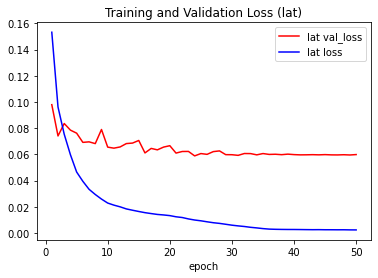

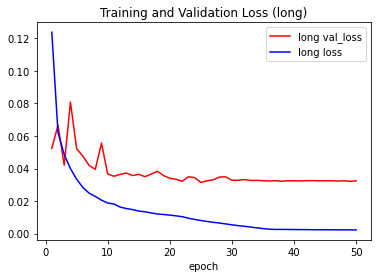

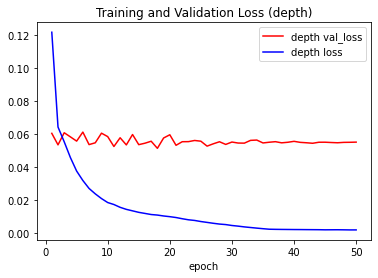

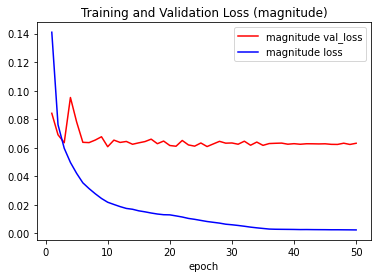

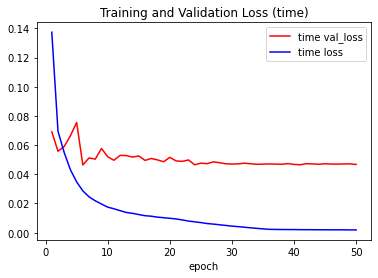

In [35]:
import matplotlib.pyplot as plt

import pickle
with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)

for output_name in y_train.keys():
    val_y = history.history["val_{}_loss".format(output_name)]
    train_y = history.history["{}_loss".format(output_name)]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.savefig(model_save_path + model.name + "/" + output_name + "_training_plot_loss.jpg")
    plt.show()

### PREDICT (BEST)

In [36]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_scores_best.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_scores_best.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

1302/1302 [==============================] - 4s 3ms/step
mae All : 0.2531127764653134
mae lat : 0.060005709528923035
mae long : 0.03251232951879501
mae depth : 0.05254550650715828
mae magnitude : 0.06086641550064087
mae time : 0.04728241264820099


In [37]:
predictions = model.predict(X_test, batch_size=batch_size)

In [38]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [39]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"best"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]

,foldername,images,pred_lat,norm_lat,pred_long,norm_long,pred_depth,norm_depth,pred_magnitude,norm_magnitude,pred_time,norm_time
0,20100106_094408crop,000300_20100106_094408_crop.png,0.588196,0.605942,0.398266,0.449586,0.175482,0.170054,0.107621,0.085714,0.181773,0.163602
1,20100106_094408crop,000301_20100106_094408_crop.png,0.575631,0.605942,0.379660,0.449586,0.168441,0.170054,0.115106,0.085714,0.186905,0.163602
2,20100106_094408crop,000302_20100106_094408_crop.png,0.588368,0.605942,0.397963,0.449586,0.167255,0.170054,0.107378,0.085714,0.176581,0.163602
3,20100106_094408crop,000303_20100106_094408_crop.png,0.575811,0.605942,0.381296,0.449586,0.169756,0.170054,0.116199,0.085714,0.187964,0.163602
4,20100106_094408crop,000304_20100106_094408_crop.png,0.584134,0.605942,0.382631,0.449586,0.169533,0.170054,0.106195,0.085714,0.180096,0.163602
5,20100106_094408crop,000305_20100106_094408_crop.png,0.565809,0.605942,0.376435,0.449586,0.169583,0.170054,0.115175,0.085714,0.191634,0.163602
6,20100106_094408crop,000306_20100106_094408_crop.png,0.591801,0.605942,0.382992,0.449586,0.163009,0.170054,0.106368,0.085714,0.178196,0.163602
7,20100106_094408crop,000307_20100106_094408_crop.png,0.584524,0.605942,0.367774,0.449586,0.166933,0.170054,0.106899,0.085714,0.184113,0.163602
8,20100106_094408crop,000308_20100106_094408_crop.png,0.594910,0.605942,0.374732,0.449586,0.167945,0.170054,0.097482,0.085714,0.177262,0.163602
9,20100106_094408crop,000309_20100106_094408_crop.png,0.568421,0.605942,0.373996,0.449586,0.159353,0.170054,0.098184,0.085714,0.184744,0.163602


### PREDICT (SWA)

In [40]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_scores_swa.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_scores_swa.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

1302/1302 [==============================] - 4s 3ms/step
mae All : 0.2563528013279727
mae lat : 0.05965006351470947
mae long : 0.032361991703510284
mae depth : 0.05480238050222397
mae magnitude : 0.06270036846399307
mae time : 0.04693331569433212


In [41]:
predictions = model.predict(X_test, batch_size=batch_size)

In [42]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [43]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"SWA"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]

,foldername,images,pred_lat,norm_lat,pred_long,norm_long,pred_depth,norm_depth,pred_magnitude,norm_magnitude,pred_time,norm_time
0,20100106_094408crop,000300_20100106_094408_crop.png,0.594138,0.605942,0.406158,0.449586,0.178187,0.170054,0.114215,0.085714,0.182892,0.163602
1,20100106_094408crop,000301_20100106_094408_crop.png,0.582393,0.605942,0.394266,0.449586,0.173841,0.170054,0.122353,0.085714,0.185828,0.163602
2,20100106_094408crop,000302_20100106_094408_crop.png,0.591124,0.605942,0.405752,0.449586,0.167277,0.170054,0.110860,0.085714,0.171293,0.163602
3,20100106_094408crop,000303_20100106_094408_crop.png,0.577638,0.605942,0.395333,0.449586,0.170133,0.170054,0.118717,0.085714,0.181537,0.163602
4,20100106_094408crop,000304_20100106_094408_crop.png,0.592054,0.605942,0.394340,0.449586,0.169035,0.170054,0.112000,0.085714,0.172524,0.163602
5,20100106_094408crop,000305_20100106_094408_crop.png,0.575148,0.605942,0.389826,0.449586,0.172906,0.170054,0.123415,0.085714,0.189538,0.163602
6,20100106_094408crop,000306_20100106_094408_crop.png,0.599266,0.605942,0.395171,0.449586,0.163301,0.170054,0.109014,0.085714,0.168647,0.163602
7,20100106_094408crop,000307_20100106_094408_crop.png,0.593552,0.605942,0.386970,0.449586,0.166687,0.170054,0.112821,0.085714,0.175314,0.163602
8,20100106_094408crop,000308_20100106_094408_crop.png,0.599558,0.605942,0.389163,0.449586,0.167780,0.170054,0.103530,0.085714,0.168158,0.163602
9,20100106_094408crop,000309_20100106_094408_crop.png,0.579364,0.605942,0.389658,0.449586,0.162463,0.170054,0.111109,0.085714,0.176494,0.163602


# MOBILENETV3

In [92]:
model = make_model(base="mobilenetv3", output_names=["lat","long","depth","magnitude","time"])
y_train = {'lat':y_train_lat,'long':y_train_long,'depth':y_train_depth,'magnitude':y_train_magnitude,'time':y_train_time}
y_valid = {'lat':y_valid_lat,'long':y_valid_long,'depth':y_valid_depth,'magnitude':y_valid_magnitude,'time':y_valid_time}
y_test = {'lat':y_test_lat,'long':y_test_long,'depth':y_test_depth,'magnitude':y_test_magnitude,'time':y_test_time}
model.name

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\keras_applications\mobilenet_v3.py:348: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


'MOBILENETV3_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_base1024-64_#2'

In [93]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.000001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [94]:
# training models
history = model.fit(X_train,y_train, 
    validation_data = (X_valid,y_valid),
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[checkpoint,swa])

Train on 11676 samples, validate on 1302 samples
Epoch 1/20
11676/11676 [==============================] - 194s 17ms/step - loss: 0.3988 - lat_loss: 0.1077 - long_loss: 0.0754 - depth_loss: 0.0622 - magnitude_loss: 0.0804 - time_loss: 0.0730 - lat_mae: 0.1077 - long_mae: 0.0754 - depth_mae: 0.0622 - magnitude_mae: 0.0804 - time_mae: 0.0730 - val_loss: 0.6036 - val_lat_loss: 0.2214 - val_long_loss: 0.1047 - val_depth_loss: 0.0574 - val_magnitude_loss: 0.1081 - val_time_loss: 0.1116 - val_lat_mae: 0.2217 - val_long_mae: 0.1049 - val_depth_mae: 0.0574 - val_magnitude_mae: 0.1081 - val_time_mae: 0.1116

Epoch 00001: val_loss improved from inf to 0.60364, saving model to ./models/28-11-2020/MOBILENETV3_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_base1024-64_#2/MOBILENETV3_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_base1024-64_#2_best.h5
Epoch 2/20
11676/11676 [==============================] - 185s 16ms/step - loss: 0.2487 - lat_loss: 0.0660 - long_loss: 0.0402 - depth_loss

In [95]:
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

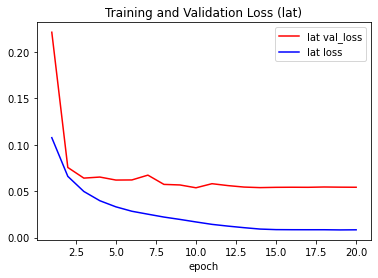

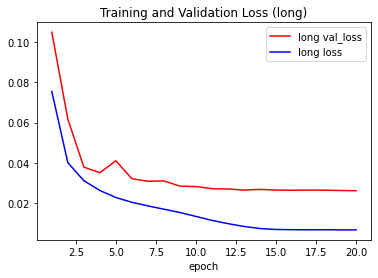

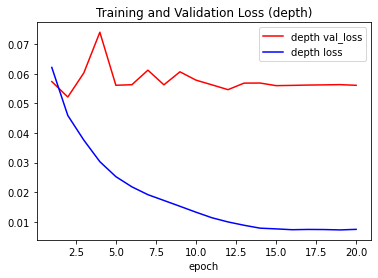

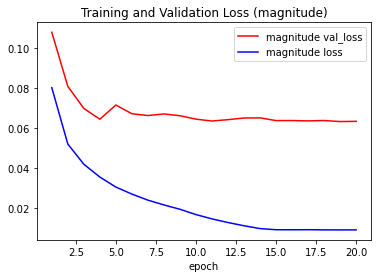

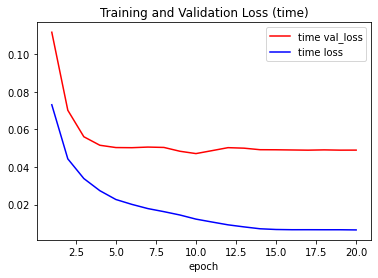

In [96]:
import matplotlib.pyplot as plt

with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)

for output_name in y_train.keys():
    val_y = history.history["val_{}_loss".format(output_name)]
    train_y = history.history["{}_loss".format(output_name)]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.savefig(model_save_path + model.name + "/" +  "_" + output_name + "_training_plot_loss.jpg")

    plt.show()

### PREDICT (BEST)

In [97]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_scores_best.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_scores_best.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

1302/1302 [==============================] - 5s 4ms/step
mae All : 0.24929909594643135
mae lat : 0.05427112057805061
mae long : 0.0262878630310297
mae depth : 0.05614534765481949
mae magnitude : 0.06356704235076904
mae time : 0.04893588274717331


In [98]:
predictions = model.predict(X_test, batch_size=batch_size)

In [99]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [100]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"best"),index=False)

df_test[df_test.foldername==df_test.foldername[0]]

,foldername,images,pred_lat,norm_lat,pred_long,norm_long,pred_depth,norm_depth,pred_magnitude,norm_magnitude,pred_time,norm_time
0,20100106_094408crop,000300_20100106_094408_crop.png,0.593502,0.605942,0.442409,0.449586,0.068238,0.170054,0.077835,0.085714,0.194754,0.163602
1,20100106_094408crop,000301_20100106_094408_crop.png,0.618790,0.605942,0.434161,0.449586,0.084960,0.170054,0.075616,0.085714,0.191322,0.163602
2,20100106_094408crop,000302_20100106_094408_crop.png,0.617769,0.605942,0.438715,0.449586,0.084245,0.170054,0.063483,0.085714,0.196295,0.163602
3,20100106_094408crop,000303_20100106_094408_crop.png,0.634928,0.605942,0.436804,0.449586,0.082527,0.170054,0.072463,0.085714,0.205524,0.163602
4,20100106_094408crop,000304_20100106_094408_crop.png,0.606826,0.605942,0.438583,0.449586,0.076511,0.170054,0.073633,0.085714,0.195168,0.163602
5,20100106_094408crop,000305_20100106_094408_crop.png,0.620178,0.605942,0.428141,0.449586,0.095451,0.170054,0.077502,0.085714,0.196489,0.163602
6,20100106_094408crop,000306_20100106_094408_crop.png,0.642082,0.605942,0.427018,0.449586,0.095330,0.170054,0.076435,0.085714,0.201011,0.163602
7,20100106_094408crop,000307_20100106_094408_crop.png,0.641358,0.605942,0.435877,0.449586,0.086716,0.170054,0.084816,0.085714,0.200960,0.163602
8,20100106_094408crop,000308_20100106_094408_crop.png,0.594732,0.605942,0.436549,0.449586,0.058323,0.170054,0.086315,0.085714,0.207098,0.163602
9,20100106_094408crop,000309_20100106_094408_crop.png,0.603345,0.605942,0.425089,0.449586,0.072795,0.170054,0.077416,0.085714,0.202105,0.163602


### PREDICT (SWA)

In [101]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_scores_swa.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_scores_swa.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

1302/1302 [==============================] - 5s 4ms/step
mae All : 0.24982872337514903
mae lat : 0.05432979762554169
mae long : 0.026466617360711098
mae depth : 0.05623357743024826
mae magnitude : 0.06373941153287888
mae time : 0.04896380379796028


In [102]:
predictions = model.predict(X_test, batch_size=batch_size)

In [103]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [104]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"SWA"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]

,foldername,images,pred_lat,norm_lat,pred_long,norm_long,pred_depth,norm_depth,pred_magnitude,norm_magnitude,pred_time,norm_time
0,20100106_094408crop,000300_20100106_094408_crop.png,0.593142,0.605942,0.442624,0.449586,0.068637,0.170054,0.076980,0.085714,0.194398,0.163602
1,20100106_094408crop,000301_20100106_094408_crop.png,0.617890,0.605942,0.434205,0.449586,0.085521,0.170054,0.074889,0.085714,0.190804,0.163602
2,20100106_094408crop,000302_20100106_094408_crop.png,0.616901,0.605942,0.438230,0.449586,0.085121,0.170054,0.062732,0.085714,0.196192,0.163602
3,20100106_094408crop,000303_20100106_094408_crop.png,0.634690,0.605942,0.436868,0.449586,0.083014,0.170054,0.071855,0.085714,0.205641,0.163602
4,20100106_094408crop,000304_20100106_094408_crop.png,0.606630,0.605942,0.438660,0.449586,0.076923,0.170054,0.073015,0.085714,0.195310,0.163602
5,20100106_094408crop,000305_20100106_094408_crop.png,0.620009,0.605942,0.428395,0.449586,0.095961,0.170054,0.076764,0.085714,0.196090,0.163602
6,20100106_094408crop,000306_20100106_094408_crop.png,0.641651,0.605942,0.427168,0.449586,0.095776,0.170054,0.075924,0.085714,0.200913,0.163602
7,20100106_094408crop,000307_20100106_094408_crop.png,0.640782,0.605942,0.436737,0.449586,0.087106,0.170054,0.084152,0.085714,0.201354,0.163602
8,20100106_094408crop,000308_20100106_094408_crop.png,0.594128,0.605942,0.436795,0.449586,0.058515,0.170054,0.085325,0.085714,0.207059,0.163602
9,20100106_094408crop,000309_20100106_094408_crop.png,0.602810,0.605942,0.425060,0.449586,0.073611,0.170054,0.076473,0.085714,0.201927,0.163602


# EFFICIENTNET 
B5

In [105]:
model = make_model(base="efficientnetb5", output_names=["lat","long","depth","magnitude","time"])
y_train = {'lat':y_train_lat,'long':y_train_long,'depth':y_train_depth,'magnitude':y_train_magnitude,'time':y_train_time}
y_valid = {'lat':y_valid_lat,'long':y_valid_long,'depth':y_valid_depth,'magnitude':y_valid_magnitude,'time':y_valid_time}
y_test = {'lat':y_test_lat,'long':y_test_long,'depth':y_test_depth,'magnitude':y_test_magnitude,'time':y_test_time}
model.name

'EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_base1024-64_#2'

In [106]:
os.listdir('./transfer')[0]

'EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_B_4_parallel_dense-v2_orthogonal_#1_best.h5'

In [107]:
## Transfer Learning
# model.load_weights('./transfer/'+os.listdir('./transfer')[0])

In [108]:
# model.name = 'EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_0s-1s_mae_B_4_par-v2_ortho_transfer_epch50'

In [109]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.00001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [110]:
# training models
history = model.fit(X_train,y_train, 
    validation_data = (X_valid,y_valid),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint,swa])

Train on 11676 samples, validate on 1302 samples
Epoch 1/20
11676/11676 [==============================] - 892s 76ms/step - loss: 0.4562 - lat_loss: 0.1190 - long_loss: 0.0951 - depth_loss: 0.0675 - magnitude_loss: 0.0936 - time_loss: 0.0811 - lat_mae: 0.1190 - long_mae: 0.0951 - depth_mae: 0.0675 - magnitude_mae: 0.0936 - time_mae: 0.0811 - val_loss: 0.3731 - val_lat_loss: 0.1019 - val_long_loss: 0.0628 - val_depth_loss: 0.0605 - val_magnitude_loss: 0.0788 - val_time_loss: 0.0689 - val_lat_mae: 0.1020 - val_long_mae: 0.0629 - val_depth_mae: 0.0605 - val_magnitude_mae: 0.0789 - val_time_mae: 0.0688

Epoch 00001: val_loss improved from inf to 0.37307, saving model to ./models/28-11-2020/EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_base1024-64_#2/EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_base1024-64_#2_best.h5
Epoch 2/20
11676/11676 [==============================] - 859s 74ms/step - loss: 0.2932 - lat_loss: 0.0746 - long_loss: 0.0530 - dept

11676/11676 [==============================] - 860s 74ms/step - loss: 0.0496 - lat_loss: 0.0106 - long_loss: 0.0100 - depth_loss: 0.0089 - magnitude_loss: 0.0121 - time_loss: 0.0081 - lat_mae: 0.0106 - long_mae: 0.0100 - depth_mae: 0.0089 - magnitude_mae: 0.0121 - time_mae: 0.0081 - val_loss: 0.2241 - val_lat_loss: 0.0420 - val_long_loss: 0.0256 - val_depth_loss: 0.0559 - val_magnitude_loss: 0.0604 - val_time_loss: 0.0403 - val_lat_mae: 0.0419 - val_long_mae: 0.0256 - val_depth_mae: 0.0559 - val_magnitude_mae: 0.0604 - val_time_mae: 0.0402

Epoch 00012: val_loss improved from 0.22982 to 0.22411, saving model to ./models/28-11-2020/EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_base1024-64_#2/EFFICIENTNETB5_multioutput_lat_long_depth_magnitude_time_5s-6s_mae_base1024-64_#2_best.h5
Epoch 13/20
11676/11676 [==============================] - 861s 74ms/step - loss: 0.0421 - lat_loss: 0.0091 - long_loss: 0.0082 - depth_loss: 0.0076 - magnitude_loss: 0.0103 - time_loss: 0.

In [111]:
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

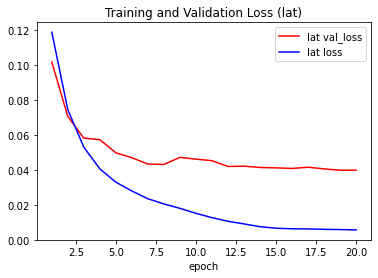

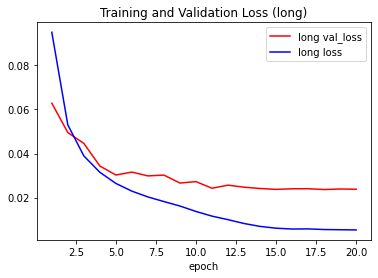

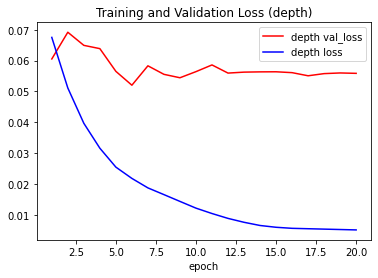

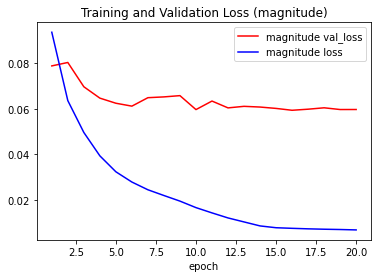

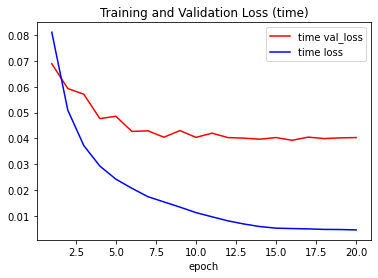

In [112]:
import matplotlib.pyplot as plt

with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)
    
for output_name in y_train.keys():
    val_y = history.history["val_{}_loss".format(output_name)]
    train_y = history.history["{}_loss".format(output_name)]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.savefig(model_save_path + model.name + "/" +  "_" + output_name + "_training_plot_loss.jpg")

    plt.show()

### PREDICT (BEST)

In [113]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

1302/1302 [==============================] - 19s 15ms/step
mae All : 0.21934357374769203
mae lat : 0.03990011289715767
mae long : 0.02377590909600258
mae depth : 0.05585593357682228
mae magnitude : 0.05967006832361221
mae time : 0.040340736508369446


In [114]:
predictions = model.predict(X_test, batch_size=batch_size)

In [115]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [116]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"best"),index=False)

df_test[df_test.foldername==df_test.foldername[0]]

,foldername,images,pred_lat,norm_lat,pred_long,norm_long,pred_depth,norm_depth,pred_magnitude,norm_magnitude,pred_time,norm_time
0,20100106_094408crop,000300_20100106_094408_crop.png,0.574284,0.605942,0.425539,0.449586,0.138904,0.170054,0.072247,0.085714,0.163413,0.163602
1,20100106_094408crop,000301_20100106_094408_crop.png,0.580730,0.605942,0.426612,0.449586,0.145570,0.170054,0.073801,0.085714,0.159524,0.163602
2,20100106_094408crop,000302_20100106_094408_crop.png,0.589880,0.605942,0.420425,0.449586,0.148746,0.170054,0.072215,0.085714,0.161135,0.163602
3,20100106_094408crop,000303_20100106_094408_crop.png,0.597721,0.605942,0.415464,0.449586,0.150293,0.170054,0.065387,0.085714,0.163146,0.163602
4,20100106_094408crop,000304_20100106_094408_crop.png,0.592533,0.605942,0.425149,0.449586,0.141535,0.170054,0.071012,0.085714,0.158919,0.163602
5,20100106_094408crop,000305_20100106_094408_crop.png,0.596923,0.605942,0.423855,0.449586,0.147713,0.170054,0.066689,0.085714,0.157067,0.163602
6,20100106_094408crop,000306_20100106_094408_crop.png,0.604930,0.605942,0.421132,0.449586,0.142883,0.170054,0.072494,0.085714,0.157558,0.163602
7,20100106_094408crop,000307_20100106_094408_crop.png,0.604153,0.605942,0.415031,0.449586,0.141692,0.170054,0.064446,0.085714,0.159181,0.163602
8,20100106_094408crop,000308_20100106_094408_crop.png,0.602895,0.605942,0.423923,0.449586,0.139992,0.170054,0.068298,0.085714,0.158546,0.163602
9,20100106_094408crop,000309_20100106_094408_crop.png,0.588511,0.605942,0.425807,0.449586,0.139986,0.170054,0.062795,0.085714,0.154793,0.163602


### PREDICT (SWA)

In [117]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

1302/1302 [==============================] - 19s 14ms/step
mae All : 0.21948470934058115
mae lat : 0.040393345057964325
mae long : 0.023779675364494324
mae depth : 0.05571964010596275
mae magnitude : 0.059747736901044846
mae time : 0.0400339737534523


In [118]:
predictions = model.predict(X_test, batch_size=batch_size)

In [119]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [120]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"SWA"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]

,foldername,images,pred_lat,norm_lat,pred_long,norm_long,pred_depth,norm_depth,pred_magnitude,norm_magnitude,pred_time,norm_time
0,20100106_094408crop,000300_20100106_094408_crop.png,0.575343,0.605942,0.429576,0.449586,0.139014,0.170054,0.069278,0.085714,0.160889,0.163602
1,20100106_094408crop,000301_20100106_094408_crop.png,0.579637,0.605942,0.429013,0.449586,0.145173,0.170054,0.071131,0.085714,0.157624,0.163602
2,20100106_094408crop,000302_20100106_094408_crop.png,0.590979,0.605942,0.422968,0.449586,0.148331,0.170054,0.068423,0.085714,0.159368,0.163602
3,20100106_094408crop,000303_20100106_094408_crop.png,0.597391,0.605942,0.417558,0.449586,0.150056,0.170054,0.062337,0.085714,0.161415,0.163602
4,20100106_094408crop,000304_20100106_094408_crop.png,0.591926,0.605942,0.425847,0.449586,0.142468,0.170054,0.069779,0.085714,0.157935,0.163602
5,20100106_094408crop,000305_20100106_094408_crop.png,0.595765,0.605942,0.424860,0.449586,0.147757,0.170054,0.064459,0.085714,0.155519,0.163602
6,20100106_094408crop,000306_20100106_094408_crop.png,0.602749,0.605942,0.422112,0.449586,0.142566,0.170054,0.069735,0.085714,0.155566,0.163602
7,20100106_094408crop,000307_20100106_094408_crop.png,0.602820,0.605942,0.416125,0.449586,0.141082,0.170054,0.060275,0.085714,0.157854,0.163602
8,20100106_094408crop,000308_20100106_094408_crop.png,0.601073,0.605942,0.424781,0.449586,0.139994,0.170054,0.066141,0.085714,0.157666,0.163602
9,20100106_094408crop,000309_20100106_094408_crop.png,0.586514,0.605942,0.426349,0.449586,0.140095,0.170054,0.060487,0.085714,0.153758,0.163602


## Single_output

### 1

In [ ]:
model = make_model(base="cnn", output_names=["lat"])
y_train = {'lat':y_train_lat}
y_valid = {'lat':y_valid_lat}
y_test = {'lat':y_test_lat}
model.name

In [ ]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.000001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# training models
history = model.fit(X_train,y_train, 
    validation_data = (X_valid,y_valid),
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[checkpoint,swa])

In [ ]:
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

In [ ]:
import matplotlib.pyplot as plt

with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)

for output_name in y_train.keys():
    val_y = history.history["val_loss"]
    train_y = history.history["loss"]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.savefig(model_save_path + model.name + "/" +  "_" + output_name + "_training_plot_loss.jpg")

    plt.show()

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"best"),index=False)

df_test[df_test.foldername==df_test.foldername[0]]

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test_-{}epoch-{}.csv'.format(epochs[-1],"SWA"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]

### 2

In [ ]:
model = make_model(base="cnn", output_names=["long"])
y_train = {'long':y_train_long}
y_valid = {'long':y_valid_long}
y_test = {'long':y_test_long}
model.name

In [ ]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.000001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# training models
history = model.fit(X_train,y_train, 
    validation_data = (X_valid,y_valid),
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[checkpoint,swa])

In [ ]:
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

In [ ]:
import matplotlib.pyplot as plt

with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)

for output_name in y_train.keys():
    val_y = history.history["val_loss"]
    train_y = history.history["loss"]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.savefig(model_save_path + model.name + "/" +  "_" + output_name + "_training_plot_loss.jpg")

    plt.show()

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"best"),index=False)

df_test[df_test.foldername==df_test.foldername[0]]

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test_-{}epoch-{}.csv'.format(epochs[-1],"SWA"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]

### 3

In [ ]:
model = make_model(base="cnn", output_names=["depth"])
y_train = {'depth':y_train_depth}
y_valid = {'depth':y_valid_depth}
y_test = {'depth':y_test_depth}
model.name

In [ ]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.000001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# training models
history = model.fit(X_train,y_train, 
    validation_data = (X_valid,y_valid),
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[checkpoint,swa])

In [ ]:
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

In [ ]:
import matplotlib.pyplot as plt

with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)
    
for output_name in y_train.keys():
    val_y = history.history["val_loss"]
    train_y = history.history["loss"]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.savefig(model_save_path + model.name + "/" +  "_" + output_name + "_training_plot_loss.jpg")

    plt.show()

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"best"),index=False)

df_test[df_test.foldername==df_test.foldername[0]]

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test_-{}epoch-{}.csv'.format(epochs[-1],"SWA"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]

### 4

In [ ]:
model = make_model(base="cnn", output_names=["magnitude"])
y_train = {'magnitude':y_train_magnitude}
y_valid = {'magnitude':y_valid_magnitude}
y_test = {'magnitude':y_test_magnitude}
model.name

In [ ]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.000001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# training models
history = model.fit(X_train,y_train, 
    validation_data = (X_valid,y_valid),
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[checkpoint,swa])

In [ ]:
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

In [ ]:
import matplotlib.pyplot as plt

with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)

for output_name in y_train.keys():
    val_y = history.history["val_loss"]
    train_y = history.history["loss"]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.savefig(model_save_path + model.name + "/" +  "_" + output_name + "_training_plot_loss.jpg")

    plt.show()

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"best"),index=False)

df_test[df_test.foldername==df_test.foldername[0]]

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test_-{}epoch-{}.csv'.format(epochs[-1],"SWA"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]

### 5

In [ ]:
model = make_model(base="cnn", output_names=["time"])
y_train = {'time':y_train_time}
y_valid = {'time':y_valid_time}
y_test = {'time':y_test_time}
model.name

In [ ]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = Nbatch

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.000001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
# training models
history = model.fit(X_train,y_train, 
    validation_data = (X_valid,y_valid),
    epochs=epochs, 
    batch_size=batch_size,
    callbacks=[checkpoint,swa])

In [ ]:
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

In [ ]:
import matplotlib.pyplot as plt

with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)
    
for output_name in y_train.keys():
    val_y = history.history["val_loss"]
    train_y = history.history["loss"]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label=output_name + " val_loss")
    plt.plot(epochs, train_y, color="blue", label=output_name + " loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation Loss ({})".format(output_name))
    plt.savefig(model_save_path + model.name + "/" +  "_" + output_name + "_training_plot_loss.jpg")

    plt.show()

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_best.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test-{}epoch-{}.csv'.format(epochs[-1],"best"),index=False)

df_test[df_test.foldername==df_test.foldername[0]]

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

if len(y_test.keys())<=1:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        text_to_write = loss_function+" "+list(y_test.keys())[0]+" : "+str(test_eval[-1])
        f.write(text_to_write)
        print(text_to_write)
else:
    with open(model_save_path + model.name + "/" + model.name + '_swa.txt', 'w') as f:
        for eval_result,col_result in zip(test_eval,['All']+list(y_test.keys())):
            text_to_write = loss_function+" "+col_result+" : "+str(eval_result)
            f.write(text_to_write+"\n")
            print(text_to_write)

In [ ]:
predictions = model.predict(X_test, batch_size=batch_size)

In [ ]:
result = {'images':test_images} 
if len(y_test.keys())<=1:
    result['pred_'+list(y_test.keys())[0]] = predictions.squeeze()
else:
    for prediction,col_result in zip(predictions,['pred_'+y_name for y_name in y_test.keys()]):
        result[col_result] = prediction.squeeze()
    
columns_result = ['images'] + [prefix+y_name for y_name in y_test.keys() for prefix in ['pred_','norm_']]

In [ ]:
df_test_pred = pd.DataFrame(result)
df_test_pred['images'] = df_test_pred.images.apply(lambda x: x[1])
df_test_pred['foldername'] = df_test_pred.images.apply(lambda x: x[7:-9]+'crop')
df_test = df[df.foldername.isin([ts[7:-9]+'crop' for ts in [te for (ft,te) in test_images]])]
df_test = df_test_pred.set_index('foldername').join(df_test.set_index('foldername'))[columns_result]
df_test = df_test.reset_index(drop=False) 
df_test.to_csv(model_save_path + model.name + "/" + 'Hasil_Test_-{}epoch-{}.csv'.format(epochs[-1],"SWA"),index=False)
df_test[df_test.foldername==df_test.foldername[0]]